In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, f_classif
import shap
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing - Nicole
Reads in `data.parquet` and `labels.parquet` files, encodes the specific cancer labels numerically with the `encoding_dict`, and merges the two datasets together.

In [2]:
data = pd.read_parquet('data.parquet')
labels = pd.read_parquet('labels.parquet')

encoding_dict = {
    'BRCA': 0,
    'KIRC': 1,
    'COAD': 2,
    'LUAD': 3,
    'PRAD': 4
}

labels['Class'] = labels['Class'].map(encoding_dict)

data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)

merged_data = pd.merge(data, labels, on='sample_id')
data = data.drop(columns=['sample_id'])
labels = labels.drop(columns=['sample_id'])

merged_data.head()

,sample_id,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,4
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,3
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,4
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,4
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,0


We examine the size of the activations across subjects for all genes tested.

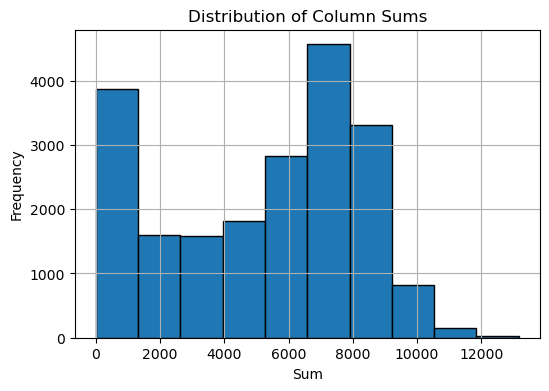

In [3]:
numeric_df = merged_data.select_dtypes(include=['number'])
column_sums = numeric_df.sum()

plt.figure(figsize=(6, 4))
plt.hist(column_sums, bins=10, edgecolor='black')
plt.title('Distribution of Column Sums')
plt.xlabel('Sum')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Quartile Ranges:
Q1 (25th percentile): 2354.2172488448955
Median (50th percentile): 6020.045465649453
Q3 (75th percentile): 7667.6631445153325
Interquartile Range (IQR): 5313.445895670437


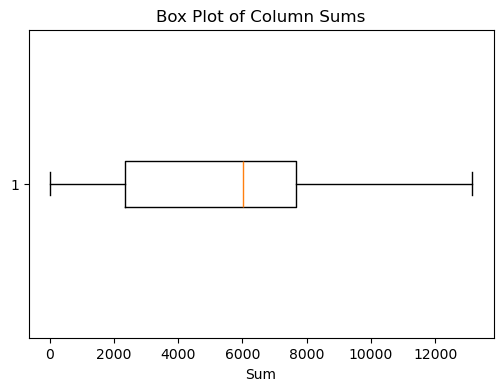

In [4]:
q1 = column_sums.quantile(0.25)
q2 = column_sums.quantile(0.50)  
q3 = column_sums.quantile(0.75)
iqr = q3 - q1

print("Quartile Ranges:")
print(f"Q1 (25th percentile): {q1}")
print(f"Median (50th percentile): {q2}")
print(f"Q3 (75th percentile): {q3}")
print(f"Interquartile Range (IQR): {iqr}")

plt.figure(figsize=(6, 4))
plt.boxplot(column_sums, vert=False)
plt.title('Box Plot of Column Sums')
plt.xlabel('Sum')
plt.show()

In [5]:
numeric_df = merged_data.select_dtypes(include=['number'])
column_sums = numeric_df.sum()
print("Columns with sum equal to 0:")
filtered_columns = column_sums[column_sums == 0]
print(filtered_columns)
print("Number of features that have only zeroes: ", len(filtered_columns))

Columns with sum equal to 0:
gene_5        0.0
gene_23       0.0
gene_4370     0.0
gene_4808     0.0
gene_4809     0.0
             ... 
gene_18915    0.0
gene_19450    0.0
gene_19451    0.0
gene_19452    0.0
gene_19671    0.0
Length: 267, dtype: float64
Number of features that have only zeroes:  267


There is a substantial number (267) of genes who show zero activation across all subjects, so we drop these from our analysis.

In [6]:
merged_data = merged_data.drop(columns = filtered_columns.index)
data = data.drop(columns = filtered_columns.index)
merged_data.head()

,sample_id,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,4
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,3
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,4
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,4
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,0


We next examine the distribution of cancer labels across subjects.

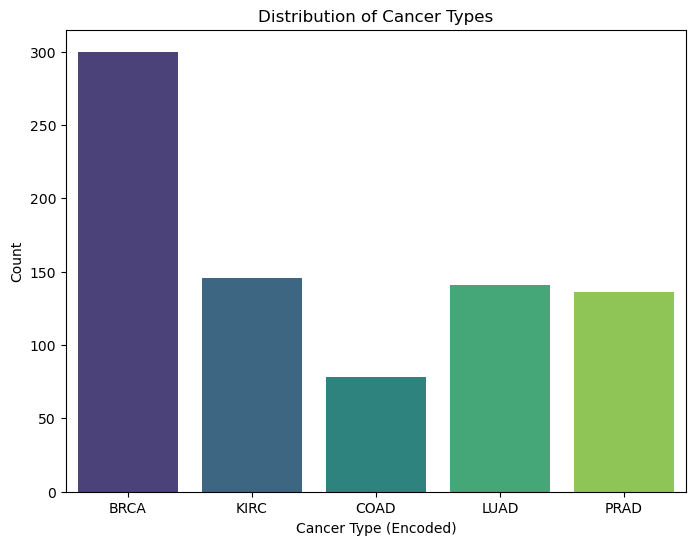

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x=labels['Class'], palette='viridis')
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Type (Encoded)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
plt.show()

Subjects with breast cancer (BRCA) appear most frequently in our dataset. Kidney (KIRC), lung (LUAD), and prostate (PRAD) cancer appear in similar frequencies. Subjects with colon cancer (COAD) appear least frequently.

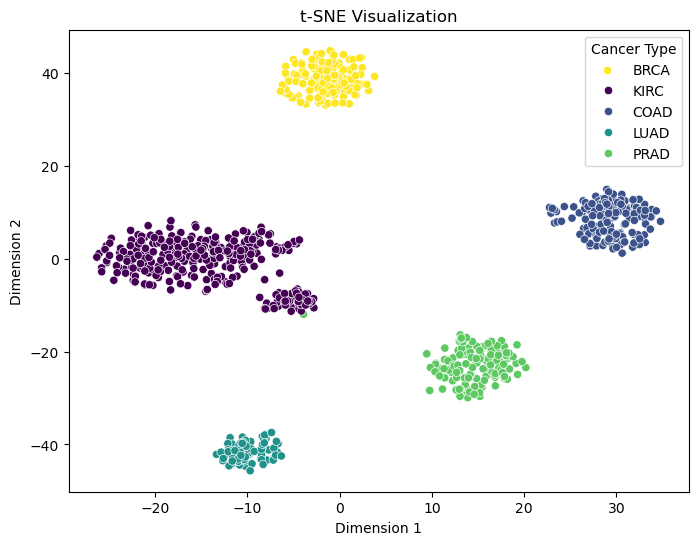

In [8]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data_tsne = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=labels['Class'], palette='viridis', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cancer Type', labels=['BRCA', 'KIRC', 'COAD', 'LUAD', 'PRAD'])
plt.show()

## Shapley Values - Nicole

In [10]:
#### Splitting Data

X = data  
y = labels 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_pred_val))

# Calculate Shapley values

explainer = shap.TreeExplainer(model)  
shap_values = explainer.shap_values(X_train)

# mean absolute Shapley value for each feature 
shap_values_mean = np.abs(shap_values).mean(axis=0)  

k = 1000  
top_k_features = np.argsort(shap_values_mean)[-k:]  
selected_features = X_train.columns[top_k_features.flatten()]

X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features] 
X_test_reduced = X_test[selected_features]

model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

y_pred_val_reduced = model_reduced.predict(X_val_reduced)
print("Validation Accuracy (Reduced):", accuracy_score(y_val, y_pred_val_reduced))
print("Classification Report (Validation - Reduced):\n", classification_report(y_val, y_pred_val_reduced))


Validation Accuracy: 1.0
Classification Report (Validation):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Validation Accuracy (Reduced): 0.55625
Classification Report (Validation - Reduced):
               precision    recall  f1-score   support

           0       0.63      0.64      0.63        61
           1       0.71      0.67      0.69        30
           2       0.75      0.63      0.69        19
           3       0.27      0.21      0.24        19
           4       0.36      0.45      0.40        31

    accuracy                         

## RF Model w/ ANOVA - Nicole

In [11]:

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
y_val = y_val.values.ravel() if hasattr(y_val, 'values') else y_val.ravel()
y_test = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()

# remove low variance features
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train)
X_val_var = variance_selector.transform(X_val)
X_test_var = variance_selector.transform(X_test)

# use SelectKBest to reduce to top 5000 features based on ANOVA F-statistic
k_best_selector = SelectKBest(f_classif, k=5000)
X_train_kbest = k_best_selector.fit_transform(X_train_var, y_train)
X_val_kbest = k_best_selector.transform(X_val_var)
X_test_kbest = k_best_selector.transform(X_test_var)

base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
base_model.fit(X_train_kbest, y_train)

# get top 1000 features based on feature importance
importances = base_model.feature_importances_
top_indices = np.argsort(importances)[-1000:]

X_train_final = X_train_kbest[:, top_indices]
X_val_final = X_val_kbest[:, top_indices]
X_test_final = X_test_kbest[:, top_indices]

# train model on reduced dataset
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train_final, y_train)

y_pred_val = final_model.predict(X_val_final)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Classification Report (Validation):\n", classification_report(y_val, y_pred_val))

# test model on test set
y_pred_test = final_model.predict(X_test_final)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_test))


Validation Accuracy: 1.0
Classification Report (Validation):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Test Accuracy: 0.9937888198757764
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      0.97      0.98        30
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        22

    accuracy                           0.99       161
   m

## Log Regression - Hanna

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#load data; load the feature data and labels from Parquet files into Pandas DataFrames
#the 'data.parquet' file contains the features, while 'labels.parquet' contains the target class labels
#https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
data = pd.read_parquet('data.parquet')
labels = pd.read_parquet('labels.parquet')

#rename columns for readability and usability
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)

#merge datasets; combine the features and labels intoa single DataFrame, joining on the common column 'sample_id'
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
merged_data = pd.merge(data, labels, on='sample_id')

#drop the sample_id column as it isn't needed for analaysis 
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
merged_data.drop(columns=['sample_id'], inplace=True)

#extract features (X) and target (y), separating the features from target label
#X has all columns except Class
X = merged_data.drop(columns=['Class'])
#Y has all the Class column, representing the labels
y = merged_data['Class']

#split the data into training and testing sets; divide dataset into training (80%) and testing (20%)
#https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#standardize features with StandardScalar to normalize values, ensuring each feature has a mean of 0 and 
#   a standard deviation of 1
#https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
#fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
#transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

#initialize logistic regression model, configured for multinomial classificaiton (>2 classes), using 'lbfgs' solver
#the 'max_iter' parameter ensures sufficient iterations for convergence, and 'random_state' ensures reproducibility
#https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

#train the model using scaled training features
log_reg.fit(X_train_scaled, y_train)

#make predictions using the trained logistic regression model
y_pred = log_reg.predict(X_test_scaled)

#evaluate the model by calculating the accuracy of the model 
#https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html
accuracy = accuracy_score(y_test, y_pred)
#generate a detailed classificiation report with precision, recall, and F1-score for each class
#https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
classification_rep = classification_report(y_test, y_pred)

#print results by displaying the accuracy and classificiation report
print("Logistic Regression")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

Logistic Regression
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        60
        COAD       0.94      0.94      0.94        16
        KIRC       1.00      1.00      1.00        30
        LUAD       0.96      0.93      0.95        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.98       161
   macro avg       0.98      0.97      0.97       161
weighted avg       0.98      0.98      0.98       161



## K-Means with PCA - Hanna

K-Means Report
Accuracy: 0.92
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       300
           1       1.00      0.99      0.99       146
           2       1.00      0.95      0.97        78
           3       0.70      0.99      0.82       141
           4       1.00      0.99      0.99       136

    accuracy                           0.92       801
   macro avg       0.94      0.95      0.94       801
weighted avg       0.94      0.92      0.92       801



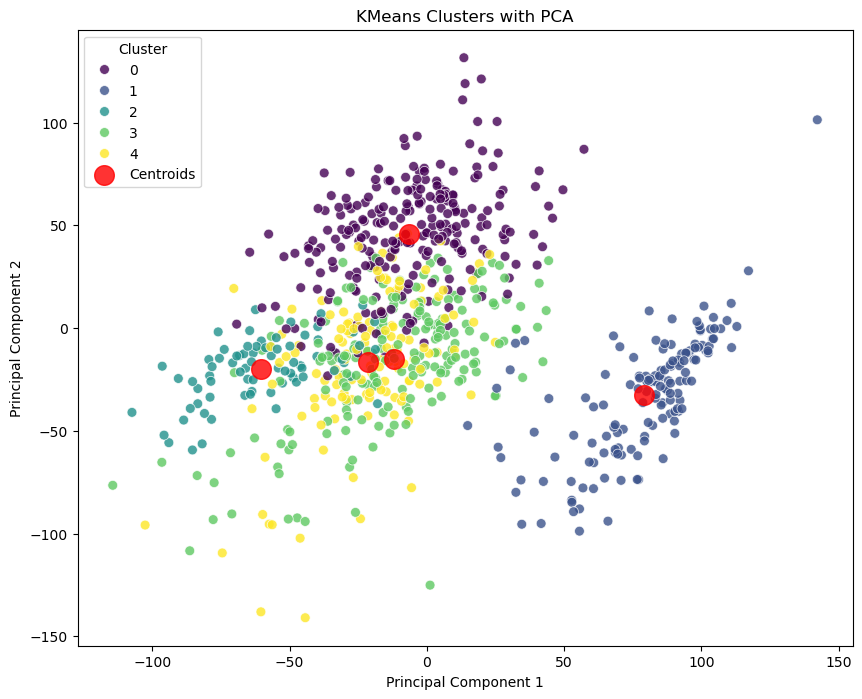

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment


#load data; load the feature data and labels from Parquet files into Pandas DataFrames
#the 'data.parquet' file contains the features, while 'labels.parquet' contains the target class labels
#https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
data = pd.read_parquet('data.parquet')
labels = pd.read_parquet('labels.parquet')

#map the labels to an encoding dicitonary to ensure consistent class mapping
labels['Class'] = labels['Class'].map(encoding_dict)

#rename columns for readability and usability
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)


#merge datasets; combine the features and labels intoa single DataFrame, joining on the common column 'sample_id'
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
merged_data = pd.merge(data, labels, on='sample_id')

#drop the sample_id column as it isn't needed for analaysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
#features
data = merged_data.drop(columns=['sample_id', 'Class'])
#labels
labels = merged_data['Class']

#standardize features with StandardScalar to normalize values, ensuring each feature has a mean of 0 and
# a standard deviation of 1
#https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
#fit and transform the training data
data_scaled = scaler.fit_transform(data)





#Grid Search CV: https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
def pca_grid_search(data, components_range):
    results = {}
    for n in components_range:
        pca = PCA(n_components=n, random_state=42)
        reduced_data = pca.fit_transform(data)
        variance_explained = sum(pca.explained_variance_ratio_)
        results[n] = variance_explained
    return results

#perform PCA grid search
#components_range = rcomponents_range = range(200, min(data_scaled.shape[1], 801), 50) # Include up to 801 or total features - 2 minutes and 6.4 seconds
max_components = min(500, data_scaled.shape[1]) # Limit to 500 components or feature count
components_range = range(50, max_components, 50) # Start from 50 with a step of 50
variance_results = pca_grid_search(data_scaled, components_range)

#find the optimal number of components (e.g., retain ~95% variance)
optimal_components = max(k for k, v in variance_results.items() if v >= 0.85)





#apply PCA for dimensionality reduction: reduce the feature set to 20 principlal components to simplify the dataset
# while retraining as much variance as possible
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=optimal_components, random_state=42)
data_reduced = pca.fit_transform(data_scaled)





#apply k-means clustering
#https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html
#define the number of clustesr
clusters = len(np.unique(labels))
#apply kmeans
k_means = KMeans(n_clusters=clusters, random_state=42, init='k-means++')
#fit the scaled down data
k_means.fit(data_reduced)
y_kmeans = k_means.predict(data_reduced)

#get clusters and centroids
cluster_labels = k_means.labels_
centroids = k_means.cluster_centers_





# #compute the contingency matrix
# #https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.cluster.contingency_matrix.html
# cont_matrix = contingency_matrix(labels, cluster_labels)

# #match each cluster to the true label with the highest count
# cluster_label_match = np.argmax(cont_matrix, axis=1)

# #map predicted cluster labels to the corresponding true labels
# mapped_cluster_labels = np.array([cluster_label_match[label] for label in cluster_labels])

from scipy.optimize import linear_sum_assignment

#compute the contingency matrix
cont_matrix = contingency_matrix(labels, cluster_labels)

#solve the optimal alignment problem
row_ind, col_ind = linear_sum_assignment(-cont_matrix) # Negative for maximization

#map cluster labels to ground truth labels
mapped_cluster_labels = np.zeros_like(cluster_labels)
for i, j in zip(row_ind, col_ind):
    mapped_cluster_labels[cluster_labels == j] = i





#accuracy and classificaition report
accuracy= accuracy_score(labels, mapped_cluster_labels)
classification_r = classification_report(labels, mapped_cluster_labels)

print("K-Means Report")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report (Test):\n", classification_r)

#silhouette score with euclidean metric
# silhouette_s = silhouette_score(X=data_scaled, labels=cluster_labels, metric='euclidean')
# print(f"Silhouette Score: {silhouette_s:.2f}")

#2d visualization using PCA (reduce to 2 dimensions for plotting)
plt.figure(figsize=(10, 8))
sns.scatterplot(
x=data_reduced[:, 0], y=data_reduced[:, 1], hue=mapped_cluster_labels, palette='viridis', s=50, alpha=0.8
)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1],
c='red', s=200, alpha=0.8, label="Centroids")
plt.title("KMeans Clusters with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()


## AdaBoost & Gradient Boosting - Jack
We next test the boosting algorithms Gradient Boosting and AdaBoost. We conduct a small hyperparameter search over the number of estimators `n_estimators` trained by these ensemble methods.

In [20]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from time import time

# get and split data
X, y = data, labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# create many classifiers for hyperparam search 
classifiers = {'AdaBoost':[],'Gradient Boosting':[]}
for n_estimators in [5,10,50,100]:
    classifiers['AdaBoost'].append(AdaBoostClassifier(n_estimators=n_estimators))
for n_estimators in [5,10]:
    classifiers['Gradient Boosting'].append(GradientBoostingClassifier(n_estimators=n_estimators))

best_classifiers = {'AdaBoost':None, 'Gradient Boosting':None}
for classifier_name, classifiers in classifiers.items():
    best_acc = 0
    for classifier in classifiers:
        # fit classifier
        start = time()
        classifier.fit(X_train, y_train)
        print(f'   {classifier} training completed in {time()-start:.2f}s')

        # conduct validation inference
        y_pred_val = classifier.predict(X_val)

        # validation accuracy and classificaition report
        accuracy = accuracy_score(y_val, y_pred_val)
        print(f"   {classifier} validation accuracy: {accuracy:.2f}")
        if accuracy > best_acc:
            best_acc = accuracy
            best_classifiers[classifier_name] = classifier

for classifier_name, classifier in best_classifiers.items():
    # conduct test inference
    y_pred_test = classifier.predict(X_test)

    # test accuracy and classificaition report
    accuracy= accuracy_score(y_test, y_pred_test)
    classification_r = classification_report(y_test, y_pred_test)
    print(f"{classifier_name} Test Accuracy: {accuracy:.2f}")
    print(f"{classifier_name} Test Report:\n{classification_r}\n")


   AdaBoostClassifier(n_estimators=5) training completed in 3.45s
   AdaBoostClassifier(n_estimators=5) validation accuracy: 0.81
   AdaBoostClassifier(n_estimators=10) training completed in 6.71s
   AdaBoostClassifier(n_estimators=10) validation accuracy: 0.99
   AdaBoostClassifier() training completed in 34.39s
   AdaBoostClassifier() validation accuracy: 0.79
   AdaBoostClassifier(n_estimators=100) training completed in 68.11s
   AdaBoostClassifier(n_estimators=100) validation accuracy: 0.79
   GradientBoostingClassifier(n_estimators=5) training completed in 40.95s
   GradientBoostingClassifier(n_estimators=5) validation accuracy: 0.99
   GradientBoostingClassifier(n_estimators=10) training completed in 85.38s
   GradientBoostingClassifier(n_estimators=10) validation accuracy: 0.99
AdaBoost Test Accuracy: 0.94
AdaBoost Test Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        62
           1       0.96      0.83      0.89 

In terms of performance, both the Gradient Boosting and AdaBoost classifiers achieve >99% validation accuracy and >94% test accuracy on the dataset, though there are some differences in the models. Gradient Boosting achieves this performance reliably, but training is an order of magnitude slower. In contrast, AdaBoost is less reliable, but trains significantly faster even with a larger number of estimators. 

## SVM - Dan

In [ ]:
# TODO

## ANN - Dan & Jack
Finally, we train an artificial neural network to predict class labels. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
torch.manual_seed(343)

# get data
X, y = data, labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(20264, 1000, bias=True)
        self.layer2 = nn.Linear(1000, 5, bias=True)

    def forward(self, input_vals):
        input_vals = torch.Tensor(input_vals)
        activation_1 = F.relu(self.layer1(input_vals))
        output = self.layer2(activation_1) 
        return output

class CustomDataset(Dataset):
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        #store data and labels, converting labels to long (integer) type
        self.data = data
        self.labels = labels.squeeze(-1).long() # Squeeze and convert to long

    def __len__(self):
        #return length of dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        #return data and label at index 'idx'
        return self.data[idx], self.labels[idx]

# tensorify train and valid data
X_train_tensor, y_train_tensor = torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train))
X_val_tensor, y_val_tensor = torch.Tensor(np.array(X_val)), torch.Tensor(np.array(y_val))

# make dataloader for batch processing
train_dataset = CustomDataset(data=X_train_tensor, labels=y_train_tensor)
# val_dataset = CustomDataset(data=X_train_tensor, labels=y_train_tensor)

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

network = ANN()
lr = 0.1
num_epochs = 1
optimizer = torch.optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, num_epochs+1):
    network.train()
    # batch processing
    for batch_X_train, batch_y_train in train_dataloader:
        optimizer.zero_grad()
        y_pred_train = network(batch_X_train)
        # one hot labels for loss 
        batch_y_train_onehot = torch.nn.functional.one_hot(batch_y_train, num_classes=5).float()
        loss_func = nn.CrossEntropyLoss()
        train_loss = loss_func(y_pred_train, batch_y_train_onehot)
        train_loss.backward()
        optimizer.step()

    # validation
    y_pred_val = network(X_val_tensor)
    y_val_onehot = torch.nn.functional.one_hot(y_val_tensor.squeeze(-1).long(), num_classes=5).float()
    val_loss = loss_func(y_pred_val, y_val_onehot)
    print(f'Validation Loss at epoch {epoch} = {val_loss:.5f}')

# testing

# tensorify testing data
X_test_tensor, y_test_tensor = torch.Tensor(np.array(X_test)), torch.Tensor(np.array(y_test))
test_activations = network(X_test_tensor)
test_inferences = torch.argmax(test_activations, dim=1)

print(test_activations)
print(test_inferences)
# print(y_test.shape)
# y_test = y_test.squeeze()
# print(y_test.shape)

acc = ((test_inferences == y_test).sum())/len(y_test)
print(f'Test accuracy = {acc*100:.5f}%.')


Validation Loss at epoch 1 = 1.55172
tensor([[ 0.0000,  3.1701,  3.0609,  ...,  9.2466,  4.8863,  0.0000],
        [ 0.0000,  2.4867,  4.0580,  ...,  9.2397,  4.3243,  0.0000],
        [ 0.0000,  0.7212,  1.6973,  ...,  9.2336,  5.7514,  0.0000],
        ...,
        [ 0.0000,  3.1445,  1.0537,  ...,  9.1136,  4.8234,  0.0000],
        [ 0.0000,  4.1436,  3.0438,  ..., 10.0942,  3.8574,  0.0000],
        [ 0.0000,  3.8099,  4.3964,  ...,  9.3209,  9.0717,  0.0000]])
tensor([[ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767,  0.1188, -0.0770],
        [ 0.3567, -0.0630, -0.3767

ValueError: Unable to coerce to Series, length must be 1: given 161